In [1]:
# script to run simulations of stream peppering
import os, os.path
import csv
import time
import pickle
import matplotlib
#matplotlib.use('agg')
import numpy
from scipy import integrate, interpolate
from optparse import OptionParser
from galpy.util import bovy_conversion
import phx_util
from scipy.integrate import quad
from scipy.optimize import brentq
import glob
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
from scipy import ndimage, signal, interpolate
from numpy.polynomial import Polynomial


Populating the interactive namespace from numpy and matplotlib


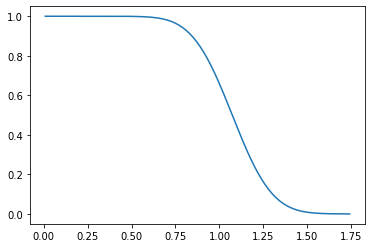

In [2]:
with open('phx_t64sampling_trailing.pkl','rb') as savefile:
    sdf_pepper_t= pickle.load(savefile,encoding='latin1')
    
with open('phx_smooth_trailing.pkl','rb') as savefile:
    sdf_smooth_t= pickle.load(savefile,encoding='latin1')
    

#check smooth density and apars
apar=np.arange(0.01,1.75,0.01)
dens_unp= [sdf_smooth_t._density_par(a) for a in apar]

plt.figure()
plt.plot(apar,dens_unp)
plt.show()
            

278.7042968995195 305.04215798355835


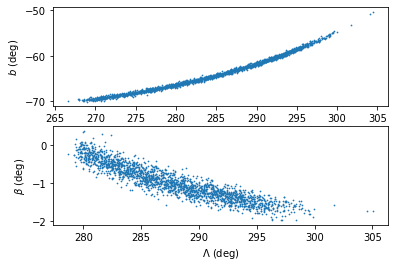

In [25]:
#sample points from the stream
from astropy import units as u
from astropy.coordinates import SkyCoord
lb_sample_sm=sdf_pepper_t.sample(n=2000,lb=True)
l_sm=lb_sample_sm[0]
b_sm=lb_sample_sm[1]

lbSkyCoord=SkyCoord(l=l_sm*u.degree,b=b_sm*u.degree,frame='galactic')
phx_coord = lbSkyCoord.transform_to(phx_util.Phoenix)

plt.figure()
plt.subplot(2,1,1)
plt.scatter(l_sm,b_sm,s=0.5)
plt.xlabel(r"$\ell$ (deg)")
plt.ylabel(r"$b$ (deg)")

plt.subplot(2,1,2)
plt.scatter(phx_coord.Lambda,phx_coord.Beta,s=0.5)
plt.xlabel(r"$\Lambda$ (deg)")
plt.ylabel(r"$\beta$ (deg)")

print (min(phx_coord.Lambda.value),max(phx_coord.Lambda.value))


In [49]:
#functions to analyze mock data

def set_ranges_and_labels_dens():
    #bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\Lambda}\,(\mathrm{deg})$')
    ylabel(r'$\sqrt{P_{\delta\delta}(k_{\Lambda})}$')
    ylim(0.01,20.)
    xlim(1.,120.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None  
def compute_nden_model(fname,nmodel=0,polydeg=3):
    Lambdas=np.linspace(280.,299.9,200)
    Ndn=np.loadtxt(fname)[nmodel]
    print (np.sum(Ndn))
    Ndn_err=numpy.sqrt(Ndn)
       
    pp= Polynomial.fit(Lambdas,Ndn,deg=polydeg,w=1/(Ndn_err))
    nden=Ndn/pp(np.array(Lambdas))
    nden_err=np.sqrt(Ndn)/pp(np.array(Lambdas))
       
    return (Lambdas,Ndn,Ndn_err,nden,nden_err,pp(np.array(Lambdas)))

def compute_pk_model(fname="",nmodel=0):
    
    Lambdas=np.linspace(280.,299.9,200)      
    _,_,_,nden,nden_err,_ = compute_nden_model(fname,nmodel=0,polydeg=3)
     
    px_dat,py_dat= signal.csd(nden,nden_err,fs=1./(Lambdas[1]-Lambdas[0]),scaling='spectrum',nperseg=len(Lambdas))
    py_dat= py_dat.real
    px_dat= 1./px_dat
    py_dat= numpy.sqrt(py_dat*(Lambdas[-1]-Lambdas[0]))
           
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err_dat= numpy.empty((nerrsim,len(px_dat)))

    ppy_noise=numpy.empty((nerrsim,len(px_dat)))

    for ii in range(nerrsim):
        tmock= nden_err*numpy.random.normal(size=len(Lambdas))
        tmock_noise= nden + nden_err*numpy.random.normal(size=len(Lambdas))
        ppy_err_dat[ii]= signal.csd(tmock,tmock,
                                fs=1./(Lambdas[1]-Lambdas[0]),scaling='spectrum',
                                nperseg=len(Lambdas))[1].real

        ppy_noise[ii]= signal.csd(tmock_noise,tmock_noise,
                                fs=1./(Lambdas[1]-Lambdas[0]),scaling='spectrum',
                                nperseg=len(Lambdas))[1].real

    py_err_dat= numpy.sqrt(numpy.median(ppy_err_dat,axis=0)*(Lambdas[-1]-Lambdas[0]))

    ppy_noise_median = numpy.sqrt(numpy.nanmedian(ppy_noise,axis=0)*(Lambdas[-1]-Lambdas[0]))
    #print (ppy_noise_median- py_dat)

    ppy_noise.sort(axis=0)

    ppy_noise_low = numpy.sqrt(ppy_noise[int(numpy.round(0.023*nerrsim))]*(Lambdas[-1]-Lambdas[0]))
    ppy_noise_high = numpy.sqrt(ppy_noise[int(numpy.round(0.977*nerrsim))]*(Lambdas[-1]-Lambdas[0]))
    
    return (px_dat,ppy_noise_median,ppy_noise_low,ppy_noise_high,py_err_dat)


2637.0


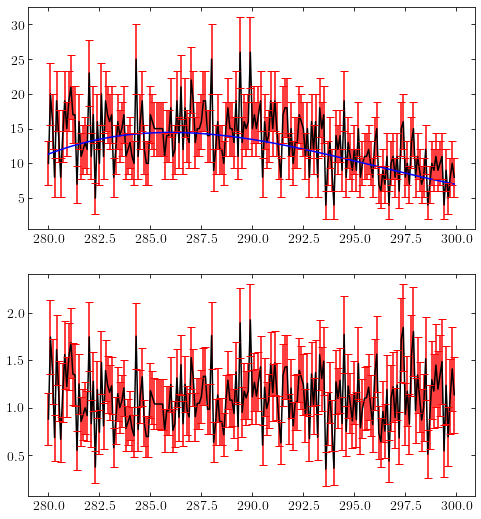

In [45]:
nn=10
lam,N,N_err,nden,nden_err,pp = compute_nden_model("LSST_galaxiax10_new",nmodel=nn)

plt.figure()
plt.subplot(2,1,1)
plt.plot(lam,N,c='k')
plt.plot(lam,pp,c='b')
plt.errorbar(lam,N,N_err,marker='None',ls='None',capsize=4.,ecolor='r')

plt.subplot(2,1,2)
plt.plot(lam,nden,c='k')
plt.errorbar(lam,nden,nden_err,marker='None',ls='None',capsize=4.,ecolor='r')
plt.show()

5507.0
/home/nil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide



Text(0, 0.5, '$\\sqrt{P_{\\delta\\delta}(k_{\\Lambda})}$')

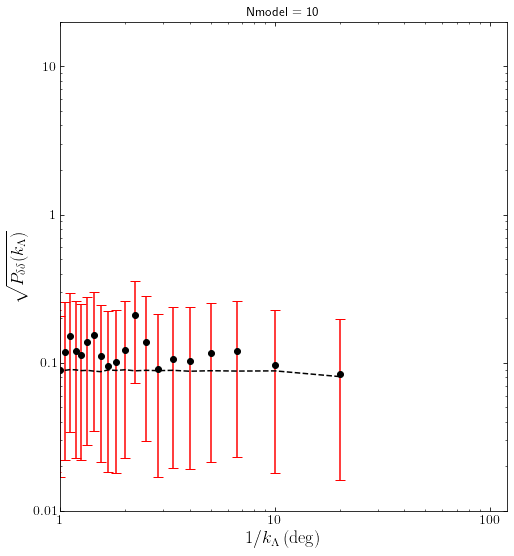

In [50]:
px_dat,ppy_noise_median,ppy_noise_low,ppy_noise_high,py_err_dat = compute_pk_model(fname="DES_galaxiax10_new",\
                                                                                   nmodel=nn)

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(8,9)
title("Nmodel = {} ".format(nmodel))
loglog(px_dat,py_err_dat,color='black',zorder=10,ls='--',label='Noise power')

errorbar(px_dat,ppy_noise_median,
         yerr=[ppy_noise_median - ppy_noise_low,ppy_noise_high - ppy_noise_median]
         ,color='k',fmt='o',capsize=5.,capthick=1.,ecolor='r',label=fname)

set_ranges_and_labels_dens()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\Lambda})}$',fontsize=18)


In [ ]:
#generate random rates in the 4 mass bins

ratemax = 1.
ratemin = -1.5

fo=open("random_4bin_rate_100K.dat","w")

for ll in range(100000):
    randrate=numpy.random.uniform(size=4)*(ratemax-ratemin)+ratemin
    randrate=10**(randrate)
    fo.write(str(randrate[0]) + "  " + str(randrate[1]) + "  " + str(randrate[2]) + "  " + str(randrate[3]) + "\n")

fo.close()

### mock data from David

[280.  280.1 280.2 280.3 280.4 280.5 280.6 280.7 280.8 280.9 281.  281.1
 281.2 281.3 281.4 281.5 281.6 281.7 281.8 281.9 282.  282.1 282.2 282.3
 282.4 282.5 282.6 282.7 282.8 282.9 283.  283.1 283.2 283.3 283.4 283.5
 283.6 283.7 283.8 283.9 284.  284.1 284.2 284.3 284.4 284.5 284.6 284.7
 284.8 284.9 285.  285.1 285.2 285.3 285.4 285.5 285.6 285.7 285.8 285.9
 286.  286.1 286.2 286.3 286.4 286.5 286.6 286.7 286.8 286.9 287.  287.1
 287.2 287.3 287.4 287.5 287.6 287.7 287.8 287.9 288.  288.1 288.2 288.3
 288.4 288.5 288.6 288.7 288.8 288.9 289.  289.1 289.2 289.3 289.4 289.5
 289.6 289.7 289.8 289.9 290.  290.1 290.2 290.3 290.4 290.5 290.6 290.7
 290.8 290.9 291.  291.1 291.2 291.3 291.4 291.5 291.6 291.7 291.8 291.9
 292.  292.1 292.2 292.3 292.4 292.5 292.6 292.7 292.8 292.9 293.  293.1
 293.2 293.3 293.4 293.5 293.6 293.7 293.8 293.9 294.  294.1 294.2 294.3
 294.4 294.5 294.6 294.7 294.8 294.9 295.  295.1 295.2 295.3 295.4 295.5
 295.6 295.7 295.8 295.9 296.  296.1 296.2 296.3 29

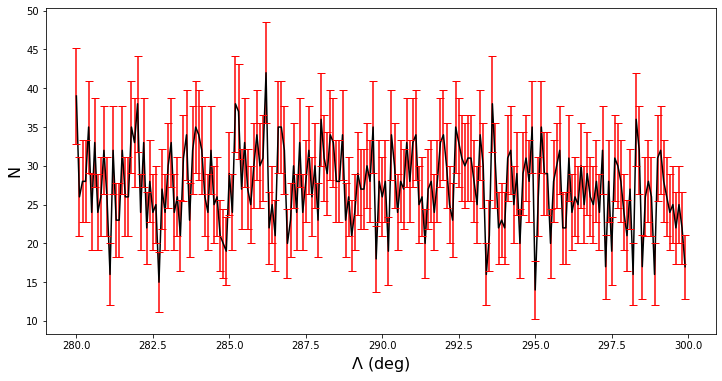

In [37]:
dat=np.loadtxt("DES_galaxiax10_new")

Lambdas=np.linspace(280.,299.9,200)

plt.figure(figsize=(12,6))
plt.subplot
plt.plot(Lambda_bins,dat[0],c='k')
plt.errorbar(Lambdas,dat[0],np.sqrt(dat[0]),marker='None',ls='None',capsize=4.,ecolor='r')
plt.xlabel(r"$\Lambda$ (deg)",fontsize=16)
plt.ylabel("N",fontsize=16)
plt.show()




15.676444916564495


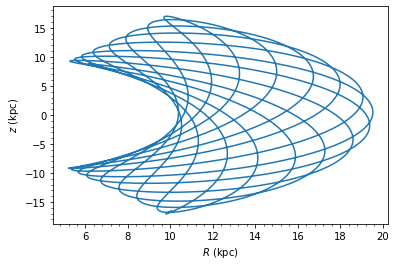

In [5]:
obs_phx = Orbit([27.60969888973802*u.deg,
  -43.54155350527743*u.deg,
  17.624735997461556*u.kpc,
  2.19712949699425679*(u.mas/u.yr),
  -0.5240686072157521*(u.mas/u.yr),
  19.93208180482703*(u.km/u.s)], \
                    radec=True,ro=8,vo=220, \
                    solarmotion=[-11.1,24.,7.25])

ts=np.linspace(0.,-4.,1000)/bovy_conversion.time_in_Gyr(220.,8.)
obs_phx.integrate(ts,MWPotential2014)

obs_phx.plot()

sp_r = np.array([obs_phx.r(ii) for ii in ts])

print (np.mean(sp_r))

In [7]:
def compute_pk_data(phi1,norm_den,norm_den_err):
    
    px_dat,py_dat= signal.csd(norm_den,norm_den,fs=1./(phi1[1]-phi1[0]),scaling='spectrum',nperseg=len(phi1))
    py_dat= py_dat.real
    px_dat= 1./px_dat
    py_dat= numpy.sqrt(py_dat*(phi1[-1]-phi1[0]))
           
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err_dat= numpy.empty((nerrsim,len(px_dat)))

    ppy_noise=numpy.empty((nerrsim,len(px_dat)))

    for ii in range(nerrsim):
        tmock= norm_den_err*numpy.random.normal(size=len(phi1))
        tmock_noise= norm_den + norm_den_err*numpy.random.normal(size=len(phi1))
        ppy_err_dat[ii]= signal.csd(tmock,tmock,
                                fs=1./(phi1[1]-phi1[0]),scaling='spectrum',
                                nperseg=len(phi1))[1].real

        ppy_noise[ii]= signal.csd(tmock_noise,tmock_noise,
                                fs=1./(phi1[1]-phi1[0]),scaling='spectrum',
                                nperseg=len(phi1))[1].real

    py_err_dat= numpy.sqrt(numpy.median(ppy_err_dat,axis=0)*(phi1[-1]-phi1[0]))

    ppy_noise_median = numpy.sqrt(numpy.nanmedian(ppy_noise,axis=0)*(phi1[-1]-phi1[0]))
    #print (ppy_noise_median- py_dat)

    ppy_noise.sort(axis=0)

    ppy_noise_low = numpy.sqrt(ppy_noise[int(numpy.round(0.023*nerrsim))]*(phi1[-1]-phi1[0]))
    ppy_noise_high = numpy.sqrt(ppy_noise[int(numpy.round(0.977*nerrsim))]*(phi1[-1]-phi1[0]))
    
    return (px_dat,ppy_noise_median,ppy_noise_low,ppy_noise_high,py_err_dat)



2637.0


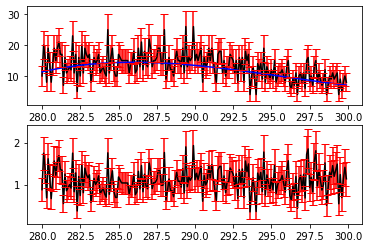

In [39]:


lam,N,N_err,nden,nden_err,pp = compute_nden_model("LSST_galaxiax10_new",nsim=10)

plt.figure()
plt.subplot(2,1,1)
plt.plot(lam,N,c='k')
plt.plot(lam,pp,c='b')
plt.errorbar(lam,N,N_err,marker='None',ls='None',capsize=4.,ecolor='r')

plt.subplot(2,1,2)
plt.plot(lam,nden,c='k')
plt.errorbar(lam,nden,nden_err,marker='None',ls='None',capsize=4.,ecolor='r')
plt.show()

In [ ]:
#fit 3rd order polynomial
pp_trail= Polynomial.fit(phi1_cut_trail,lin_den_cut_trail,deg=3,w=1/(elin_den_cut_trail))

pp_phi2_lead= Polynomial.fit(phi1_cut_lead,phi2_cut_lead,deg=3,w=1/(ephi2_cut_lead))   # for track
pp_phi2_trail= Polynomial.fit(phi1_cut_trail,phi2_cut_trail,deg=3,w=1/(ephi2_cut_trail))   # for track

#normalize density, track and errors
norm_den_lead = lin_den_cut_lead/pp_lead(phi1_cut_lead)
norm_den_err_lead = elin_den_cut_lead/pp_lead(phi1_cut_lead)
norm_phi2_cut_lead= phi2_cut_lead - pp_phi2_lead(phi1_cut_lead)

norm_den_trail = lin_den_cut_trail/pp_trail(phi1_cut_trail)
norm_den_err_trail = elin_den_cut_trail/pp_trail(phi1_cut_trail)
norm_phi2_cut_trail= phi2_cut_trail - pp_phi2_trail(phi1_cut_trail)


plt.figure(figsize=(12,8))
ax1=plt.subplot(3,1,1)
ax1.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=False)
plt.plot(phi1_cut,lin_den_cut,c='k')
plt.errorbar(phi1_cut,lin_den_cut,elin_den_cut,ls='None',capsize=2.,ecolor='r')
#plt.ylim(2100,5000)
plt.xlabel([])
plt.xlim(-65.,0.)
#plt.xticks([])
#plt.ylabel('Star count',fontsize=16)
#plt.legend(loc='lower right',fontsize=16)

ax2=plt.subplot(3,1,2)
ax2.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=False) 
plt.plot(phi1_cut_lead,pp_lead(phi1_cut_lead),c='k',label=r'$3^{\rm{rd}}$ order polynomial')
plt.errorbar(phi1_cut_lead,lin_den_cut_lead,elin_den_cut_lead,c='b',marker='None',capsize=4.,ecolor='b')
plt.plot(phi1_cut_lead,lin_den_cut_lead,c='b',label='Leading')

plt.plot(phi1_cut_trail,pp_trail(phi1_cut_trail),c='k')
plt.plot(phi1_cut_trail,lin_den_cut_trail,c='r',label='Trailing')
plt.errorbar(phi1_cut_trail,lin_den_cut_trail,elin_den_cut_trail,c='r',marker='None',capsize=4.,ecolor='r')
plt.ylabel(r'Linear density (deg$^{-1}$)',fontsize=16)
#plt.text(0.42,0.85,'Smooth',fontsize=16,transform=ax1.transAxes)
plt.xlim(-65.,0.)
plt.ylim(-0.3,8.8)
#plt.legend(loc='upper right',fontsize=14)
plt.xlabel([])
plt.xtick_labelsize=0.


ax3=plt.subplot(3,1,3)
ax3.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.) 
plt.text(0.33,0.85,r'Divided by $3^{\rm{rd}}$ order polynomial',fontsize=15,transform=ax3.transAxes)
plt.plot(phi1_cut_lead,norm_den_lead,c='b')
plt.plot(phi1_cut_trail,norm_den_trail,c='r')
plt.errorbar(phi1_cut_lead,norm_den_lead,norm_den_err_lead,c='b',marker='None',capsize=4.,ecolor='b')
plt.errorbar(phi1_cut_trail,norm_den_trail,norm_den_err_trail,c='r',marker='None',capsize=4.,ecolor='r')
#plt.ylim(0.3,2.0)
plt.xlim(-65.,0.)
plt.ylim(0.4,1.6)
plt.xlabel(r'$\phi_{1}$ (deg)',fontsize=16)
plt.ylabel(r'Normalized density',fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig('paper_plots/GD1_norm_density_short_12degcut_phi1-40.pdf',bbox_inches='tight')
plt.show()


In [ ]:
px_trail,ppy_noise_median_trail,ppy_noise_low_trail,ppy_noise_high_trail,py_err_trail = compute_pk_data(phi1_cut_trail,norm_den_trail,norm_den_err_trail)

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(15,9)
subplot(1,2,1)
loglog(px_lead,py_err_lead,color='red',zorder=10,ls='--',label='Noise power')

errorbar(px_lead,ppy_noise_median_lead,
         yerr=[ppy_noise_median_lead - ppy_noise_low_lead,ppy_noise_high_lead - ppy_noise_median_lead]
         ,color='r',fmt='o',capsize=5.,capthick=1.,ecolor='r',label='Gaia + PanSTARRS')

set_ranges_and_labels_dens()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',fontsize=18)

subplot(1,2,2)
loglog(px_trail,py_err_trail,color='red',zorder=10,ls='--',label='Noise power')

errorbar(px_trail,ppy_noise_median_trail,
         yerr=[ppy_noise_median_trail - ppy_noise_low_trail,ppy_noise_high_trail - ppy_noise_median_trail]
         ,color='r',fmt='o',capsize=5.,capthick=1.,ecolor='r',label='Gaia + PanSTARRS')

set_ranges_and_labels_dens_noY()
gca().xaxis.set_major_formatter(plt.NullFormatter())
subplots_adjust(wspace=0.,hspace=0.)



In [ ]:
dat=np.loadtxt(folder + 'Phx_4bin_densOmega_onlysubhalo_Plummer_Mmin105_batch0_0.dat')
dat1=np.loadtxt(folder + 'Phx_4bin_densOmega_onlysubhalo_Plummer_Mmin105_batch0_1.dat')

plt.figure()
plt.plot(dat[:,4],dat[:,6])
plt.plot(dat1[:,4],dat1[:,6])
plt.show()

In [31]:
def compute_obs_density_phx(lamda,apars,dens_apar,Omega): #lambda spelled wrong, bc of lambda func
    
    apar_edge=[]
    lamda_edge=[]

    abw0=apars[1]-apars[0]
    apar_edge.append(apars[0]-(abw0/2.))

    lamdabw0=lamda[1]-lamda[0]
    lamda_edge.append(lamda[0]-(lamdabw0/2.))
    
    for ii in range(len(apars)-1):
        abw=apars[ii+1]-apars[ii]
        lamdabw=lamda[ii+1]-lamda[ii]
        apar_edge.append(apars[ii]+abw/2.)
        lamda_edge.append(lamda[ii]+lamdabw/2.)
    
    abw_last=apars[len(apars)-1]-apars[len(apars)-2]
    apar_edge.append(apars[len(apars)-1]+(abw_last/2.))

    lamdabw_last=lamda[len(lamda)-1]-lamda[len(lamda)-2]
    lamda_edge.append(lamda[len(lamda)-1]+(lamdabw_last/2.))
    #print (lamda_edge)
    #compute the Jacobian d(apar)/d(lamda) using finite difference method
    dapar_dlamda=np.fabs(numpy.diff(apar_edge)/numpy.diff(lamda_edge))
    #print (dapar_dlamda)
   
    #Interpolate dens(apar)
    ipdens_apar= interpolate.InterpolatedUnivariateSpline(apars,dens_apar)

    #Interpolate apar(lamda)
    if lamda[1] < lamda[0] : # ad-hoc way of checking whether increasing or decreasing
        iplamda= interpolate.InterpolatedUnivariateSpline(lamda[::-1],apars[::-1])
        #Interpolate Jacobian
        ipdapar_dlamda=interpolate.InterpolatedUnivariateSpline(lamda[::-1],dapar_dlamda[::-1])
        #Interpolate density(lamda) by multiplying by jacobian
        dens_lamda=interpolate.InterpolatedUnivariateSpline(lamda[::-1],\
                                                            ipdens_apar(iplamda(lamda[::-1]))*ipdapar_dlamda(lamda[::-1]))
        
    else :
        iplamda= interpolate.InterpolatedUnivariateSpline(lamda,apars)
        #Interpolate Jacobian
        ipdapar_dlamda=interpolate.InterpolatedUnivariateSpline(lamda,dapar_dlamda)
        #Interpolate density(lamda) by multiplying by jacobian
        dens_lamda=interpolate.InterpolatedUnivariateSpline(lamda,ipdens_apar(iplamda(lamda))*ipdapar_dlamda(lamda))
       
    return (dens_lamda(lamda))

In [ ]:
Lambda_bins=np.linspace(280.,300.,201)
print (Lambda_bins)
phx_dens=compute_obs_density_phx(Lambda_bins,dat[:,4],dat[:,6],dat[:,8])
phx_dens1=compute_obs_density_phx(Lambda_bins,dat1[:,4],dat1[:,6],dat1[:,8])

plt.figure()
plt.plot(Lambda_bins,phx_dens)
plt.plot(Lambda_bins,phx_dens1)
plt.show()



2.6059279928188928 6.806851173634648 0.08830603835097645 0.9054027355840146


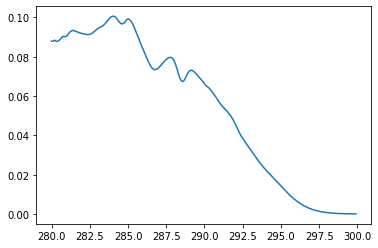

In [36]:
#collect all the densOmega files, convert them to observed coordinates and write them out to a single file

def compute_obs_dens_from_file_4bin(fname):
    dat=np.loadtxt(fname)
    xcdm1=dat[:,0][0]
    xcdm2=dat[:,1][0]
    xcdm3=dat[:,2][0]
    xcdm4=dat[:,3][0]
    apars=dat[:,4]
    dens_smooth=dat[:,5]
    dens=dat[:,6]
    Omega=dat[:,8]
    Lambdas=np.linspace(280.,299.9,200)
    dens_lamda = compute_obs_density_phx(Lambdas,apars,dens,Omega)
    
    return (xcdm1,xcdm2,xcdm3,xcdm4,Lambdas,dens_lamda)

folder = "dens_Omega/Phx_dens_Omega_4bins_randrate-1p5_1/"

fname = folder + 'Phx_4bin_densOmega_onlysubhalo_Plummer_Mmin105_2800.dat'
x1,x2,x3,x4,ll,densl= compute_obs_dens_from_file_4bin(fname)

print (x1,x2,x3,x4)

plt.figure()
plt.plot(ll,densl)
#plt.plot(Lambda_bins,phx_dens1)
plt.show()

In [ ]:
def compute_power_diff_4bins_margTage(dir='dens_Omega/sims_for_ABC_loguniform_rate_4bin_margTage/',Nind=50,len_threshold=0.2,RaoblackwellizeN=100):
                  
       
    px_dat_tr,py_noise_med_tr,py_noise_low_tr,py_noise_high_tr,py_err_dat_tr = compute_pk_data(arm='trailing')
    px_dat_le,py_noise_med_le,py_noise_low_le,py_noise_high_le,py_err_dat_le = compute_pk_data(arm='leading')
       
    
    fot = open(dir + 'ABC_4bin_minmax2_power_diff_trailing_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w',newline='')
    fol = open(dir + 'ABC_4bin_minmax2_power_diff_leading_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w',newline='')
    
    fowritert= csv.writer(fot,delimiter=',')
    fowriterl= csv.writer(fol,delimiter=',')
    
    fowritert.writerow([pp for pp in px_dat_tr[1:]])
    fowriterl.writerow([pp for pp in px_dat_le[1:]])
    
    #get the phi1 from the data
    outphi1t,_,_,norm_data_errt,_,_=get_data(arm='trailing')
    outphi1l,_,_,norm_data_errl,_,_=get_data(arm='leading')
    
    trail_len=36.
    lead_len=20.
    err_count=0
    for bb in range(Nbatch):
        for ind in range(Nind):
            jj = (bb*batchsize) + ind
            Tage = rand_age[jj]
            sigv=np.round((0.3*3.2)/Tage,2)
            #print (bb,jj,sigv)
            midphi1_lead,pert_lead=np.loadtxt('combine_bar_spiral_subhalos/GD1_{}Gyr_sigv{}_leading_barspiral_1M_perturbation.dat'.format(Tage,sigv),unpack=True)
            midphi1_trail,pert_trail=np.loadtxt('combine_bar_spiral_subhalos/GD1_{}Gyr_sigv{}_trailing_barspiral_1M_perturbation.dat'.format(Tage,sigv),unpack=True)
            
            ip_lead_pert=interpolate.InterpolatedUnivariateSpline(midphi1_lead,pert_lead)
            ip_trail_pert=interpolate.InterpolatedUnivariateSpline(midphi1_trail,pert_trail)
            
               
            with open('pkl_files/pklfiles_{}Gyr_sigv{}/gd1_smooth_pepper_trailing_Plummer_sigv{}_td{}_64sampling_progphi1-40.0_MW2014.pkl'.format(Tage,sigv,sigv,Tage),'rb') as savefile:
                sdf_smooth_t= pickle.load(savefile,encoding='latin1')
                sdf_pepper_t= pickle.load(savefile,encoding='latin1')
            
            with open('pkl_files/pklfiles_{}Gyr_sigv{}/gd1_smooth_pepper_leading_Plummer_sigv{}_td{}_64sampling_progphi1-40.0_MW2014.pkl'.format(Tage,sigv,sigv,Tage),'rb') as savefile:
                sdf_smooth_l= pickle.load(savefile,encoding='latin1')
                sdf_pepper_l= pickle.load(savefile,encoding='latin1')
            
              
            fnamet=dir1_tr + 'GD1_prog-40.0_sigv{}_trailing_4bin_minmax2_densOmega_subhalo_GMC_Plummer_Mmin105_rand_rotate_batch{}_{}.dat'.format(sigv,bb,ind)  
            fnamel=dir1_le + 'GD1_prog-40.0_sigv{}_leading_4bin_minmax2_densOmega_subhalo_GMC_Plummer_Mmin105_rand_rotate_batch{}_{}.dat'.format(sigv,bb,ind)  
            
            try:
                _,xcdm1,xcdm2,xcdm3,xcdm4,phi1_t,dens_phi1_t = compute_obs_dens_from_file_4bin(fnamet,sdf_pepper_t)
                _,_,_,_,_,phi1_l,dens_phi1_l = compute_obs_dens_from_file_4bin(fnamel,sdf_pepper_l)
                print (xcdm1,xcdm2,xcdm3,xcdm4,Tage)
                pert_BS_lead=ip_lead_pert(phi1_l)
                pert_BS_trail=ip_trail_pert(phi1_t)

                #add perturbation due to the bar + spiral
                dens_phi1_l+=pert_BS_lead
                dens_phi1_t+=pert_BS_trail

                #compute length
                l_trail=compute_length(phi1_t,dens_phi1_t,arm='trailing',threshold=len_threshold)
                l_lead=compute_length(phi1_l,dens_phi1_l,arm='leading',threshold=len_threshold)
                
                mean_den_l=np.mean(dens_phi1_l[(phi1_l >= -44.) & (phi1_l <= -40.)])
                mean_den_t=np.mean(dens_phi1_t[(phi1_t >= -40.) & (phi1_t <= -36.)])
                plt.figure(figsize=(10,6))
                plt.subplot(1,2,1)
                plt.plot(phi1_l,dens_phi1_l)
                plt.hlines(0.2*mean_den_l,-35,-100)
                plt.vlines(-60.,0.,0.01)
                
                plt.subplot(1,2,2)
                plt.plot(phi1_t,dens_phi1_t)
                plt.hlines(0.2*mean_den_t,-45,0.)
                plt.vlines(-4.,0.,0.01)
                plt.show()

                #if either arm is shorter than observed then PENALIZE! 
                if (l_trail < trail_len) | (l_lead < lead_len) :
                    #print (l10rate,l_trail, l_lead)
                    print ("rejected")
                    prej_tr = 100.*np.ones(len(px_dat_tr)-1) #some huge number so that this gets rejected
                    prej_le = 100.*np.ones(len(px_dat_le)-1) #some huge number so that this gets rejected

                    prej_tr=np.insert(prej_tr,0,[xcdm1,xcdm2,xcdm3,xcdm4,Tage])
                    prej_le=np.insert(prej_le,0,[xcdm1,xcdm2,xcdm3,xcdm4,Tage])
                    for ii in range(RaoblackwellizeN+1):
                        fowritert.writerow([p1 for p1 in prej_tr])
                        fowriterl.writerow([p1 for p1 in prej_le])

                else :

                    _,dens_cont_tr=compute_dens_cont(phi1_t,dens_phi1_t,outphi1t)
                    _,dens_cont_le=compute_dens_cont(phi1_l,dens_phi1_l,outphi1l)

                    px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,dens_cont_tr,arm='trailing',CDM=True,scaling='spectrum')
                    px_sim_le,py_sim_le = compute_pk_sim(outphi1l,dens_cont_le,arm='leading',CDM=True,scaling='spectrum')

                    diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                    diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])

                    diff_t=np.insert(diff_t,0,[xcdm1,xcdm2,xcdm3,xcdm4,Tage])
                    diff_l=np.insert(diff_l,0,[xcdm1,xcdm2,xcdm3,xcdm4,Tage])

                    fowritert.writerow([pp for pp in diff_t])
                    fowriterl.writerow([pp for pp in diff_l])

                    for jj in range(RaoblackwellizeN):
                        tdens_tr= dens_cont_tr+numpy.random.normal(size=len(outphi1t))*norm_data_errt
                        tdens_le= dens_cont_le+numpy.random.normal(size=len(outphi1l))*norm_data_errl

                        px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,tdens_tr,arm='trailing',CDM=True,scaling='spectrum')
                        px_sim_le,py_sim_le = compute_pk_sim(outphi1l,tdens_le,arm='leading',CDM=True,scaling='spectrum')

                        diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                        diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])

                        diff_t=np.insert(diff_t,0,[xcdm1,xcdm2,xcdm3,xcdm4,Tage])
                        diff_l=np.insert(diff_l,0,[xcdm1,xcdm2,xcdm3,xcdm4,Tage])

                        fowritert.writerow([pp for pp in diff_t])
                        fowriterl.writerow([pp for pp in diff_l])

            except ValueError as e:
                    pass
                    err_count+=1
                    #print (jj)
                    #print (e)
                    #os.rename(jj, trash_dir + fn) #move buggy realizations to trash 
    fot.flush()
    fol.flush()
    fot.close() 
    fol.close() 
    print (err_count)
    return None
            
            